# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [1]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [3]:
transforms_cifar10 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2) #batchsize 수정

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2) #training에서의 batchsize와 맞춰주기

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


 ship  deer horse  bird


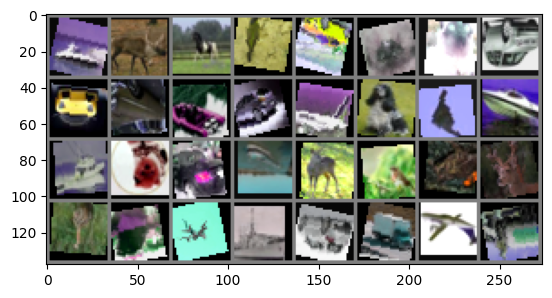

In [4]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

make network

In [5]:

class BasicBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channel)

        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.conv2(out)))
        return out

# E_Net 모델 정의
class E_Net(nn.Module):
    def __init__(self):
        super(E_Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(4)

        self.layer1 = BasicBlock(4, 4, stride=1)
        self.layer2 = BasicBlock(4, 16, stride=2)
        self.layer3 = BasicBlock(16, 32, stride=2)
        self.layer4 = BasicBlock(32, 64, stride=2)
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# 모델 초기화
net = E_Net().to(device)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [6]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [7]:
# 각 학습률에 해당하는 epochs. epoch을 20, 20, 10으로 나누어서 돌린다.
epochs = [20, 20, 10]

for num_epochs in epochs:
    for epoch in range(num_epochs):
        epoch_loss = 0.0  # 각 epoch의 손실 초기화

        for i, data in enumerate(trainloader, start=1):
            # Load the data
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Estimate the output using the network
            outputs = net(inputs)

            # Calculate the loss between the output of the network and label
            loss = criterion(outputs, labels)

            # Optimize the network
            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step()

            epoch_loss += loss.item()  # mini-batch 손실을 누적

            if i % 5000 == 0:  # Print loss every 5000 mini-batches
                print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                      (epoch + 1, i, epoch_loss / i))

        # 에포크가 끝날 때마다 해당 에포크의 평균 손실 출력
        print('[Epoch - %d] Loss: %.3f' % (epoch + 1, epoch_loss / len(trainloader)))

        # Update the learning rate according to the learning rate scheduler
        scheduler.step()

    print('Finished Training for current learning rate')

print('Finished Training')

[Epoch - 1] Loss: 1.934
[Epoch - 2] Loss: 1.773
[Epoch - 3] Loss: 1.723
[Epoch - 4] Loss: 1.677
[Epoch - 5] Loss: 1.648
[Epoch - 6] Loss: 1.625
[Epoch - 7] Loss: 1.609
[Epoch - 8] Loss: 1.591
[Epoch - 9] Loss: 1.574
[Epoch - 10] Loss: 1.562
[Epoch - 11] Loss: 1.523
[Epoch - 12] Loss: 1.525
[Epoch - 13] Loss: 1.519
[Epoch - 14] Loss: 1.518
[Epoch - 15] Loss: 1.510
[Epoch - 16] Loss: 1.514
[Epoch - 17] Loss: 1.509
[Epoch - 18] Loss: 1.504
[Epoch - 19] Loss: 1.504
[Epoch - 20] Loss: 1.502
Finished Training for current learning rate
[Epoch - 1] Loss: 1.497
[Epoch - 2] Loss: 1.503
[Epoch - 3] Loss: 1.490
[Epoch - 4] Loss: 1.491
[Epoch - 5] Loss: 1.499
[Epoch - 6] Loss: 1.500
[Epoch - 7] Loss: 1.496
[Epoch - 8] Loss: 1.498
[Epoch - 9] Loss: 1.497
[Epoch - 10] Loss: 1.499
[Epoch - 11] Loss: 1.499
[Epoch - 12] Loss: 1.496
[Epoch - 13] Loss: 1.490
[Epoch - 14] Loss: 1.498
[Epoch - 15] Loss: 1.493
[Epoch - 16] Loss: 1.497
[Epoch - 17] Loss: 1.490
[Epoch - 18] Loss: 1.499
[Epoch - 19] Loss: 1.496

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:  horse  ship   car plane


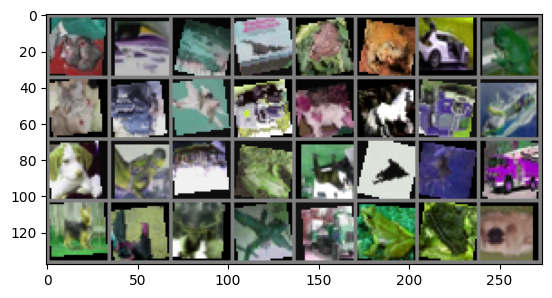

In [8]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [9]:
# Test the trained model with overall test dataset

correct = 0
total = 0

net.eval()
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 87 %
